Preparing data

In [ ]:
from pycocotools.coco import COCO
import cv2
import os

img_dir = "C:/Users/georg/Downloads/val2017/val2017"
ann_file = "C:/Users/georg/Downloads/annotations_trainval2017/annotations/instances_val2017.json"

out_root = "data_coco_small"
os.makedirs(os.path.join(out_root, "pedestrian"), exist_ok=True)
os.makedirs(os.path.join(out_root, "cyclist"), exist_ok=True)
os.makedirs(os.path.join(out_root, "car"), exist_ok=True)

coco = COCO(ann_file)

cat_ids_person  = coco.getCatIds(catNms=['person'])
cat_ids_bicycle = coco.getCatIds(catNms=['bicycle'])
cat_ids_car     = coco.getCatIds(catNms=['car'])

cat_to_classname = {}
for cid in cat_ids_person:
    cat_to_classname[cid] = "pedestrian"
for cid in cat_ids_bicycle:
    cat_to_classname[cid] = "cyclist"
for cid in cat_ids_car:
    cat_to_classname[cid] = "car"

all_cat_ids = list(cat_to_classname.keys())
ann_ids = coco.getAnnIds(catIds=all_cat_ids)
anns = coco.loadAnns(ann_ids)

max_crops_per_class = 300  # 300 per class
count_per_class = {"pedestrian": 0, "cyclist": 0, "car": 0}

crop_idx = 0
for ann in anns:
    cat_id = ann['category_id']
    class_name = cat_to_classname[cat_id]

    if count_per_class[class_name] >= max_crops_per_class:
        continue  # enough for this class

    x, y, w, h = ann['bbox']
    x, y, w, h = int(x), int(y), int(w), int(h)

    img_info = coco.loadImgs(ann['image_id'])[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    img = cv2.imread(img_path)
    if img is None:
        continue

    crop = img[y:y+h, x:x+w]
    if crop.size == 0:
        continue

    crop = cv2.resize(crop, (224, 224))

    out_path = os.path.join(out_root, class_name, f"{crop_idx:06d}.jpg")
    cv2.imwrite(out_path, crop)

    crop_idx += 1
    count_per_class[class_name] += 1

    if all(count_per_class[c] >= max_crops_per_class for c in count_per_class):
        break

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


Training

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import cv2
import os

# ----------------------------------------
# 1. Settings
# ----------------------------------------
data_dir = "/zhome/5d/8/225087/data_coco_small"   # root folder pedestrian/cyclist/car
batch_size = 32
num_epochs = 10
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------
# 2. Transforms & Dataset
# ----------------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
        std=[0.229, 0.224, 0.225]
    )
])

# Training set
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# ----------------------------------------
# 3. Model (ResNet-18 pretrained)
# ----------------------------------------
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

# ----------------------------------------
# 4. Loss & Optimizer
# ----------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ----------------------------------------
# 5. Training loop
#    (training loss & accuracy)
# ----------------------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # στατιστικά
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_loss:.4f}  Train Acc: {epoch_acc:.4f}")

# ----------------------------------------
# 6. Save model
# ----------------------------------------
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names,
}, "resnet18_ped_cyc_car_coco.pth")

print("Model saved to resnet18_ped_cyc_car_coco.pth")


Using device: cuda
Classes: ['car', 'cyclist', 'pedestrian']
Epoch [1/10]  Train Loss: 0.4899  Train Acc: 0.7900
Epoch [2/10]  Train Loss: 0.1485  Train Acc: 0.9511
Epoch [3/10]  Train Loss: 0.0667  Train Acc: 0.9844
Epoch [4/10]  Train Loss: 0.0316  Train Acc: 0.9922
Epoch [5/10]  Train Loss: 0.0329  Train Acc: 0.9956
Epoch [6/10]  Train Loss: 0.0223  Train Acc: 0.9933
Epoch [7/10]  Train Loss: 0.0320  Train Acc: 0.9933
Epoch [8/10]  Train Loss: 0.0854  Train Acc: 0.9778
Epoch [9/10]  Train Loss: 0.0422  Train Acc: 0.9878
Epoch [10/10]  Train Loss: 0.0162  Train Acc: 0.9978
Model saved to resnet18_ped_cyc_car_coco.pth


Libraries (for independent evaluation)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import cv2
import os

Validation

In [ ]:
from collections import defaultdict

def load_gt_file(gt_path):
    """
    Return dict: frame_id -> list of {"bbox":[x1,y1,x2,y2], "class": class}
    """
    gt = defaultdict(list)
    with open(gt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 10:
                continue
            frame_id = int(parts[0])
            # track_id = int(parts[1])
            cls = parts[2]  # 'Car', 'Cyclist', 'Pedestrian'

            try:
                x1 = float(parts[6])
                y1 = float(parts[7])
                x2 = float(parts[8])
                y2 = float(parts[9])
            except:
                # adjust indices
                continue

            if cls not in ["Car", "Cyclist", "Pedestrian"]:
                continue

            gt[frame_id].append({
                "bbox": [x1, y1, x2, y2],
                "class": cls
            })
    return gt

Total samples: 4018
Accuracy: 0.9133897461423593
Confusion matrix (rows=GT, cols=pred):
[[ 819   17    0]
 [  39  228  106]
 [ 119   67 2623]]
class order: ['car', 'cyclist', 'pedestrian']
Saved confusion_matrix.png


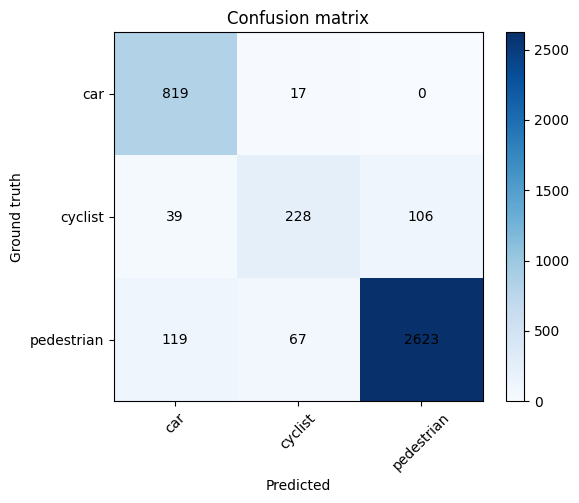

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ---------- Settings ----------
checkpoint_path = "resnet18_ped_cyc_car_coco.pth"
seq1_gt_path = "/zhome/5d/8/225087/rect_images/seq_01/labels.txt" 
seq2_gt_path = "/zhome/5d/8/225087/rect_images/seq_02/labels.txt"
seq1_dir = "/zhome/5d/8/225087/rect_images/seq_01/images/data"  
seq2_dir = "/zhome/5d/8/225087/rect_images/seq_02/images/data"
# --------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(checkpoint_path, map_location=device)
class_names = ckpt["class_names"]  # ['pedestrian','cyclist','car']

model = models.resnet18(weights=None)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(class_names))
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def classify_crop_bgr(crop_bgr):
    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(crop_rgb)
    input_t = transform(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(input_t)
        probs = torch.softmax(out, dim=1)[0].cpu().numpy()
        idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# load GT
gt_seq1 = load_gt_file(seq1_gt_path)
gt_seq2 = load_gt_file(seq2_gt_path)

mapping_label = {"Pedestrian":"pedestrian","Cyclist":"cyclist","Car":"car"}
class_to_idx = {name:i for i,name in enumerate(class_names)}
num_classes = len(class_names)
conf_mat = np.zeros((num_classes, num_classes), dtype=int)
total = 0
correct = 0

def evaluate_sequence(gt_dict, seq_dir, is_sequence_2):
    global total, correct, conf_mat
    for frame_id, objs in gt_dict.items():
        if is_sequence_2:
            frame_name = f"{frame_id:010d}"  # 10 digits (Sequence 2)
        else:
            frame_name = f"{frame_id:06d}"  # 6 digits (Sequence 1)
        frame_path = os.path.join(seq_dir, f"{frame_name}.png")
        img = cv2.imread(frame_path)
        if img is None:
            # εναλλακτικά .jpg
            frame_path_jpg = os.path.join(seq_dir, f"{frame_name}.jpg")
            img = cv2.imread(frame_path_jpg)
            if img is None:
                print("Cannot read frame", frame_path)
                continue

        for obj in objs:
            x1,y1,x2,y2 = obj["bbox"]
            x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
            # clamp
            h,w = img.shape[:2]
            x1 = max(0, min(x1, w-1)); x2 = max(0, min(x2, w-1))
            y1 = max(0, min(y1, h-1)); y2 = max(0, min(y2, h-1))
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img[y1:y2, x1:x2]
            if crop.size == 0:
                continue

            pred_class, conf = classify_crop_bgr(crop)
            gt_raw = obj["class"]  # "Car", "Cyclist", "Pedestrian"
            gt_mapped = mapping_label[gt_raw]  # map to lowercase names used in class_names

            i_gt = class_to_idx[gt_mapped]
            i_pred = class_to_idx[pred_class]

            conf_mat[i_gt, i_pred] += 1
            total += 1
            if pred_class == gt_mapped:
                correct += 1

# run
evaluate_sequence(gt_seq1, seq1_dir, False)
evaluate_sequence(gt_seq2, seq2_dir, True)

accuracy = correct / total if total>0 else 0.0
print("Total samples:", total)
print("Accuracy:", accuracy)
print("Confusion matrix (rows=GT, cols=pred):")
print(conf_mat)
print("class order:", class_names)

# save heatmap
plt.figure(figsize=(6,5))
plt.imshow(conf_mat, interpolation='nearest', cmap='Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, conf_mat[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
print("Saved confusion_matrix.png")

Loading the model

In [ ]:
# classifier_model.py
import torch
from torchvision import models, transforms
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "resnet18_ped_cyc_car_coco.pth"

# checkpoint
ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
class_names = ckpt["class_names"]

model = models.resnet18(weights=None)
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(class_names))
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def classify_crop_bgr(crop_bgr):
    """
    Input: crop at OpenCV format (BGR),
    -> PyTorch tensor -> return:
      - predicted_class (string)
      - confidence (float)
    """
    if crop_bgr is None or crop_bgr.size == 0:
        return None, 0.0

    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(crop_rgb)
    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        confidence = probs[pred_idx].item()

    return class_names[pred_idx], confidence

if __name__ == "__main__":
    print("Loaded classifier with classes:", class_names)


Loaded classifier with classes: ['car', 'cyclist', 'pedestrian']


Testing

In [ ]:
# detect_and_label_seq3.py
import os
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
# from classifier_model import classify_crop_bgr, device
import numpy as np

SEQ3_DIR = "/zhome/5d/8/225087/rect_images/seq_03/images/data"
OUT_VIDEO = "seq3_labeled.avi"
FPS = 10

# 1. pretrained Faster R-CNN (COCO)
print("Loading detector...")
detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
detector.to(device)
detector.eval()
print("Detector loaded.")

# COCO IDs:
# person: 1, bicycle: 2, car: 3
COCO_PERSON_ID = 1
COCO_BICYCLE_ID = 2
COCO_CAR_ID = 3

VALID_COCO_IDS = {COCO_PERSON_ID, COCO_BICYCLE_ID, COCO_CAR_ID}

# Map from COCO label -> generic label
COCO_TO_NAME = {
    COCO_PERSON_ID: "person",
    COCO_BICYCLE_ID: "bicycle",
    COCO_CAR_ID: "car",
}

# 2. list of frames at SEQ3_DIR
frame_files = sorted(
    [f for f in os.listdir(SEQ3_DIR) if f.lower().endswith((".png", ".jpg"))]
)
if not frame_files:
    raise RuntimeError(f"No frames found in {SEQ3_DIR}")

# Image size
sample_frame = cv2.imread(os.path.join(SEQ3_DIR, frame_files[0]))
if sample_frame is None:
    raise RuntimeError("Cannot read sample frame.")

height, width = sample_frame.shape[:2]

# 3. VideoWriter
fourcc = cv2.VideoWriter_fourcc(*"XVID")
video_writer = cv2.VideoWriter(OUT_VIDEO, fourcc, FPS, (width, height))

print("Processing frames...")
for idx, fname in enumerate(frame_files):
    frame_path = os.path.join(SEQ3_DIR, fname)
    frame_bgr = cv2.imread(frame_path)
    if frame_bgr is None:
        print("Could not read frame:", frame_path)
        continue

    # ---- Preparing image for detector ----
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(frame_rgb).to(device)  # [C,H,W], float32, [0,1]

    with torch.no_grad():
        output = detector([img_tensor])[0]

    boxes = output["boxes"]      # [N, 4]
    labels = output["labels"]    # [N]
    scores = output["scores"]    # [N]

    # ---- Filtering detections ----
    # threshold score > 0.5
    score_thresh = 0.5

    for box, lbl, score in zip(boxes, labels, scores):
        if score < score_thresh:
            continue
        coco_id = int(lbl.item())
        if coco_id not in VALID_COCO_IDS:
            continue

        x1, y1, x2, y2 = box.cpu().numpy()
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        # clamp
        x1 = max(0, min(x1, width - 1))
        x2 = max(0, min(x2, width - 1))
        y1 = max(0, min(y1, height - 1))
        y2 = max(0, min(y2, height - 1))
        if x2 <= x1 or y2 <= y1:
            continue

        crop_bgr = frame_bgr[y1:y2, x1:x2]

        # ---- Send crop to my classifier ----
        pred_class, conf = classify_crop_bgr(crop_bgr)
        if pred_class is None:
            continue

        # bounding box + label on the frame
        color = (0, 255, 0)  # green
        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)

        text = f"{pred_class} {conf:.2f}"
        # COCO_TO_NAME[coco_id]
        # text = f"{pred_class} ({COCO_TO_NAME[coco_id]}) {conf:.2f}"

        # text on the box
        y_text = max(15, y1 - 5)
        cv2.putText(
            frame_bgr,
            text,
            (x1, y_text),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
            cv2.LINE_AA,
        )

    # annotated frame on video
    video_writer.write(frame_bgr)

    if (idx + 1) % 10 == 0:
        print(f"Processed {idx+1}/{len(frame_files)} frames")

video_writer.release()
print("Done! Saved video:", OUT_VIDEO)


Loading detector...
Detector loaded.
Processing frames...
Processed 10/145 frames
Processed 20/145 frames
Processed 30/145 frames
Processed 40/145 frames
Processed 50/145 frames
Processed 60/145 frames
Processed 70/145 frames
Processed 80/145 frames
Processed 90/145 frames
Processed 100/145 frames
Processed 110/145 frames
Processed 120/145 frames
Processed 130/145 frames
Processed 140/145 frames
Done! Saved video: seq3_labeled1.avi
